## STEP 1. IMPORTS 

In [128]:
# for data manipulation
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from plotly.offline import iplot

# for data modelling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor



# for metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
ConfusionMatrixDisplay,confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error


### LOAD DATASETS

In [129]:
df = pd.read_csv('IMDb_Movies_India.csv', encoding='latin1')

## STEP 2. DATA EXPLORATION (INITIAL EDA AND DATA CLEANING) 

In [130]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [131]:
df['Genre'].value_counts()

Genre
Drama                         2780
Action                        1289
Thriller                       779
Romance                        708
Drama, Romance                 524
                              ... 
Action, Musical, War             1
Horror, Crime, Thriller          1
Animation, Comedy                1
Romance, Action, Crime           1
Adventure, Fantasy, Sci-Fi       1
Name: count, Length: 485, dtype: int64

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [133]:
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [134]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [135]:
df.duplicated().sum()

6

Here we can notice that there is very much null values and less duplicated values which we can drop but for the null values we have to work smartly

In [136]:
df = df.drop_duplicates(keep='first')

There is no point in imputing nan values of movie duration hence we replace it by 0

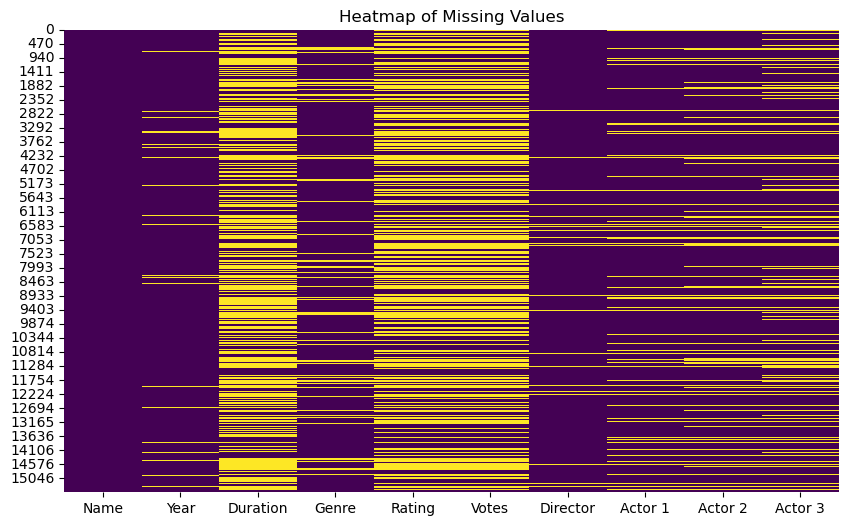

In [137]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)  # 'viridis' is an example; you can choose other color maps like 'coolwarm', 'magma', etc.
plt.title('Heatmap of Missing Values')
plt.show()

In [138]:
df['Duration'] = df['Duration'].fillna('0').astype(str)

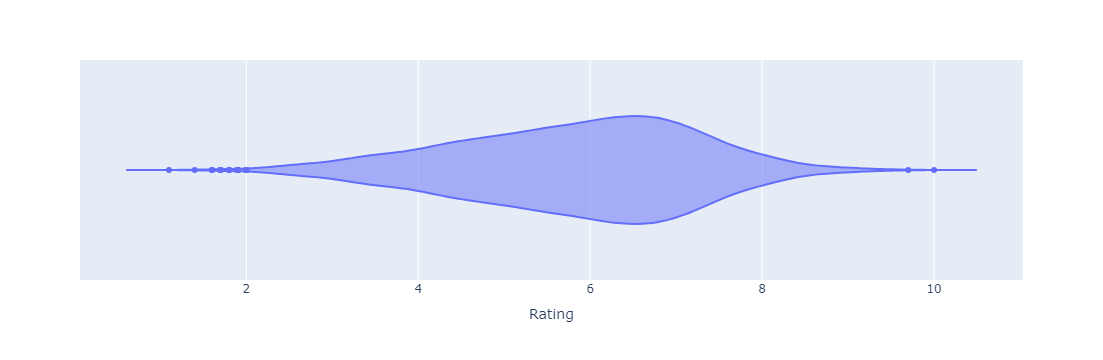

In [139]:
iplot(px.violin(data_frame=df,x="Rating"))

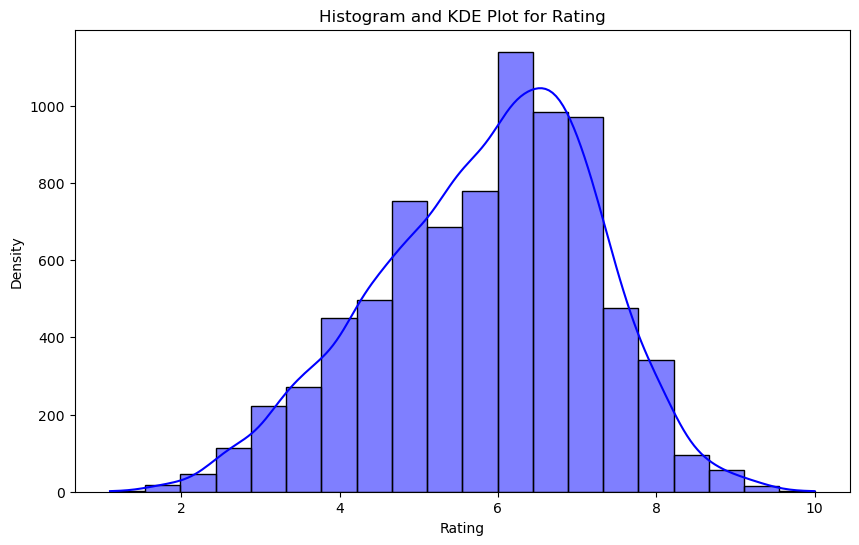

In [140]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], kde=True, color='blue', bins=20)
plt.title('Histogram and KDE Plot for Rating')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

From above two visualization it is clear that the rating column is normally distributed and then it is safe to replace nan values with its mean 

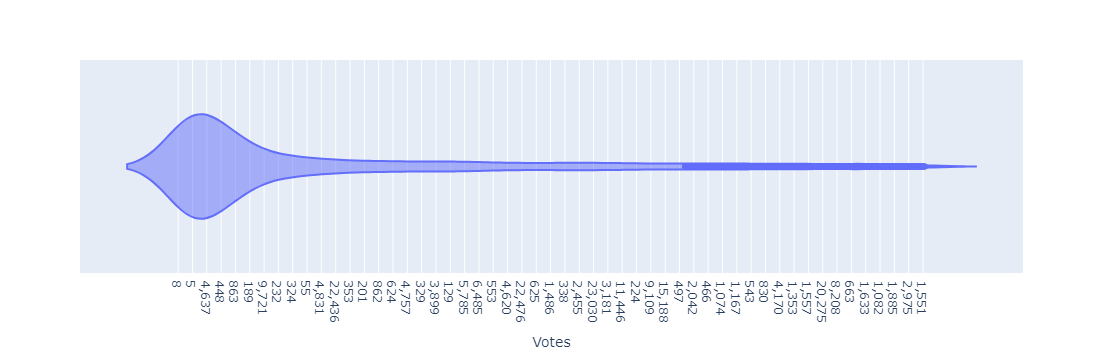

In [141]:
iplot(px.violin(data_frame=df,x="Votes"))

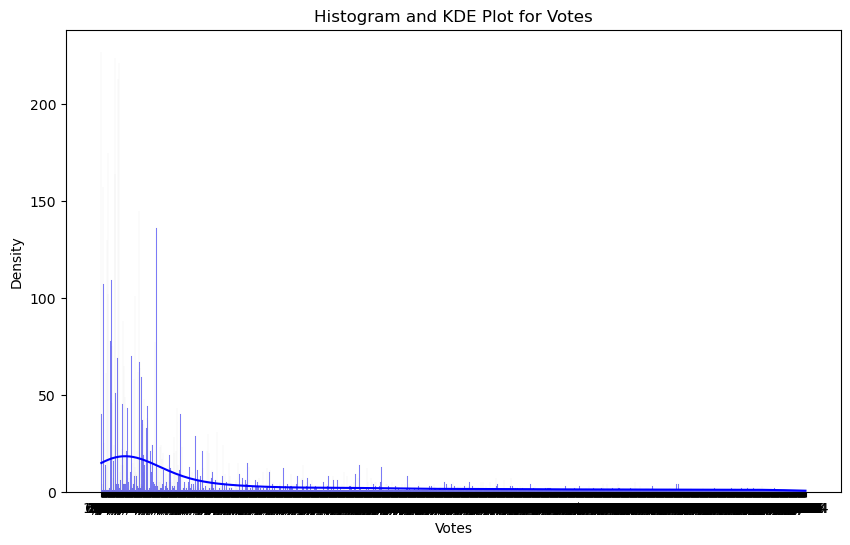

In [142]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Votes'], kde=True, color='blue', bins=20)
plt.title('Histogram and KDE Plot for Votes')
plt.xlabel('Votes')
plt.ylabel('Density')
plt.show()

Votes column has serious outliers 

In [143]:
df = df.dropna(subset =['Year'])
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [144]:
#cleaning the data
df["Year"]=df["Year"].str.strip("()").astype(int)
df["Duration"]=df["Duration"].str.replace(" min","").astype(int)


In [145]:
top_10_movies=df[["Name","Genre","Rating"]].sort_values(by="Rating",ascending=False).head(10)
print("TOP_10 based on ratings")
top_10_movies

TOP_10 based on ratings


,Name,Genre,Rating
8339,Love Qubool Hai,"Drama, Romance",10.0
5410,Half Songs,"Music, Romance",9.7
2563,Breed,Drama,9.6
11704,Ram-Path,Documentary,9.4
14222,The Reluctant Crime,Drama,9.4
6852,June,Drama,9.4
5077,Gho Gho Rani,"History, Romance",9.4
1314,Ashok Vatika,Drama,9.3
5125,God of gods,Documentary,9.3
12673,Secrets of Sinauli,"Documentary, History",9.3


In [146]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,2021,90,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,2010,105,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


we can replace 0 duration movies with median of duration of the same genre 

In [147]:
median_duration_by_genre = df.groupby('Genre')['Duration'].median()
df['Duration'] = df['Duration'].astype(float)
for genre, median_dur in median_duration_by_genre.items():
    df.loc[(df['Duration'] == 0) & (df['Genre'] == genre), 'Duration'] = median_dur
print("\nRows with Duration == 0 after replacement:")
print(df['Duration'].value_counts())


Rows with Duration == 0 after replacement:
Duration
0.0      6254
135.0     299
120.0     282
121.0     243
57.0      235
         ... 
85.5        1
202.0       1
255.0       1
75.5        1
141.5       1
Name: count, Length: 213, dtype: int64


In [148]:
median_duration_by_director = df.groupby('Director')['Duration'].median()
for director, median_duration in median_duration_by_director.items():
    df.loc[(df['Duration'] == 0) & (df['Director'] == director), 'Duration'] = median_duration
print("\nCount of each Duration value:")
print(df['Duration'].value_counts())


Count of each Duration value:
Duration
0.0      4998
135.0     345
120.0     307
121.0     292
133.0     257
         ... 
85.5        1
202.0       1
255.0       1
75.5        1
29.0        1
Name: count, Length: 295, dtype: int64


In [149]:
actors=['Actor 1','Actor 2',  'Actor 3']
for actor in actors:
    median_duration_by_actor = df.groupby(actor)['Duration'].median()
    for act, median_duration in median_duration_by_actor.items():
        df.loc[(df['Duration'] == 0) & (df[actor] == act), 'Duration'] = median_duration
    print(f"\nCount of each Duration value: when grouping by {actor}")
    print(df['Duration'].value_counts())


Count of each Duration value: when grouping by Actor 1
Duration
0.00      3890
135.00     367
120.00     328
133.00     315
121.00     313
          ... 
159.50       1
126.25       1
247.00       1
211.00       1
76.50        1
Name: count, Length: 346, dtype: int64

Count of each Duration value: when grouping by Actor 2
Duration
0.000      2918
135.000     380
121.000     347
120.000     342
133.000     320
           ... 
29.625        1
2.000         1
107.500       1
223.000       1
76.500        1
Name: count, Length: 390, dtype: int64

Count of each Duration value: when grouping by Actor 3
Duration
0.0      2314
121.0     405
135.0     383
120.0     344
133.0     327
         ... 
111.5       1
25.5        1
247.0       1
79.5        1
76.5        1
Name: count, Length: 432, dtype: int64


321


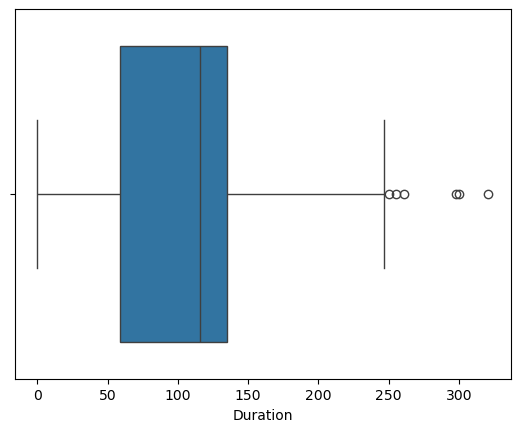

In [150]:
df['Duration']=df['Duration'].astype(int)
sns.boxplot(x=df['Duration'])
print(max(df['Duration']))

In [151]:
df=df.dropna(subset=['Duration'],axis=0)
df=df[df['Duration'] >= 60]

In [152]:
df[df['Duration']==0]

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3


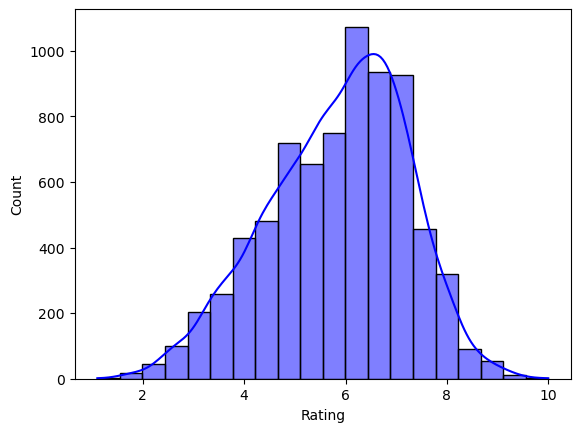

In [153]:
sns.histplot(df['Rating'], kde=True, color='blue', bins=20);

In [154]:
df=df.dropna(subset=['Rating'],axis=0)


In [155]:
# cleaning votes
df["Votes"]=df["Votes"].str.replace(",","").astype(int)

In [156]:
df['Director'].mode()

0    Mahesh Bhatt
Name: Director, dtype: object

In [157]:
df["Director"]=df["Director"].fillna('Dilip Bose')

In [158]:
df.isna().sum()

Name          0
Year          0
Duration      0
Genre        65
Rating        0
Votes         0
Director      0
Actor 1      76
Actor 2     124
Actor 3     189
dtype: int64

In [159]:
df['Genre'] = df['Genre'].str.split(', ')
df = df.explode('Genre')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,#Yaaram,2019,110,Romance,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,Comedy,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,Drama,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [160]:
df['Genre'] = df['Genre'].fillna(df['Genre'].mode())

In [161]:
df=df.dropna(subset=['Actor 1','Actor 2','Actor 3'],axis=0)

By not droping the rows directly in the start we saved great data loss

In [162]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,#Yaaram,2019,110,Romance,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,Comedy,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,Drama,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [163]:
df['Genre'].value_counts()

Genre
Drama          4763
Action         2275
Romance        1746
Comedy         1523
Crime          1098
Thriller        848
Family          636
Musical         486
Mystery         359
Adventure       354
Horror          256
Fantasy         183
Biography       124
History         113
Music            56
Sport            45
Documentary      43
Animation        42
Sci-Fi           34
War              33
News              1
Western           1
Name: count, dtype: int64

In [164]:
g_mean_rat = df.groupby('Genre')['Rating'].transform('mean')
df['Gen_mean_rat'] = g_mean_rat

dir_mean_rat = df.groupby('Director')['Rating'].transform('mean')
df['Dir_enc'] = dir_mean_rat

a1_mean_rat = df.groupby('Actor 1')['Rating'].transform('mean')
df['A1_enc'] = a1_mean_rat

a2_mean_rat = df.groupby('Actor 2')['Rating'].transform('mean')
df['A2_enc'] = a2_mean_rat

a3_mean_rat = df.groupby('Actor 3')['Rating'].transform('mean')
df['A3_enc'] = a3_mean_rat

In [165]:
df = df.dropna()

In [166]:
X = df[['Year', 'Votes', 'Duration', 'Gen_mean_rat', 'Dir_enc', 'A1_enc', 'A2_enc', 'A3_enc']]
y = df['Rating']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [168]:
model=LinearRegression().fit(X_train,y_train)
y_pred=model.predict(X_test)

In [169]:
mse=mean_squared_error(y_pred,y_test)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR LR")
print(mse)


print("R2_SCORE FOR LR")
print(r2_score)

MSE FOR LR
0.45411031935267093
R2_SCORE FOR LR
0.7501548587209781


In [173]:
model=DecisionTreeRegressor().fit(X_train,y_train)
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR DTR")
print(mse)

print("R2_SCORE FOR DTR")
print(r2_score)

MSE FOR DTR
0.19145672436751002
R2_SCORE FOR DTR
0.8946631901767683


In [174]:
model=SVR().fit(X_train,y_train)
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR SVR")
print(mse)
print("R2_SCORE FOR SVR")
print(r2_score)

MSE FOR SVR
1.7374391076771012
R2_SCORE FOR SVR
0.04408532283504474


In [175]:
model=RandomForestRegressor().fit(X_train,y_train)
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR RFR")
print(mse)


print("R2_SCORE FOR RFR")
print(r2_score)

MSE FOR RFR
0.1271413278295606
R2_SCORE FOR RFR
0.9300486210944059


In [176]:
model=GradientBoostingRegressor().fit(X_train,y_train)
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR GBR")
print(mse)

print("R2_SCORE FOR ABR")
print(r2_score)

MSE FOR GBR
0.3484849070682912
R2_SCORE FOR ABR
0.8082684820635712


In [178]:
model=XGBRegressor().fit(X_train,y_train)
y_pred=model.predict(X_test)

mse=mean_squared_error(y_test,y_pred)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_pred)

print("MSE FOR XGBR")
print(mse)
print("R2_SCORE FOR XGBR")
print(r2_score)

MSE FOR XGBR
0.18495163984447074
R2_SCORE FOR XGBR
0.8982421966261428
